In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ikn-metadata/open-meteo_IKN_rill.csv


In [2]:
!pip install attention

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from attention import Attention
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
df = pd.read_csv('/kaggle/input/ikn-metadata/open-meteo_IKN_rill.csv', engine= 'pyarrow')

In [5]:
df

,time,temperature_2m_best_match (°C),relativehumidity_2m_best_match (%),dewpoint_2m_best_match (°C),apparent_temperature_best_match (°C),pressure_msl_best_match (hPa),surface_pressure_best_match (hPa),precipitation_best_match (mm),rain_best_match (mm),snowfall_best_match (cm),...,et0_fao_evapotranspiration_era5_land (mm),vapor_pressure_deficit_era5_land (kPa),soil_temperature_0_to_7cm_era5_land (°C),soil_temperature_7_to_28cm_era5_land (°C),soil_temperature_28_to_100cm_era5_land (°C),soil_temperature_100_to_255cm_era5_land (°C),soil_moisture_0_to_7cm_era5_land (m³/m³),soil_moisture_7_to_28cm_era5_land (m³/m³),soil_moisture_28_to_100cm_era5_land (m³/m³),soil_moisture_100_to_255cm_era5_land (m³/m³)
0,2000-01-01T00:00,23.4,98,23,28.5,1008.3,1002.2,0.3,0.3,0,...,#NUM!,0.07,25.6,27.1,26.7,26.6,0.436,0.427,0.427,0.434
1,2000-01-01T01:00,23.2,98,22.9,28.2,1008.1,1002,0.2,0.2,0,...,#NUM!,0.04,25.4,27,26.7,26.6,0.436,0.427,0.427,0.434
2,2000-01-01T02:00,23.3,99,23.1,28.2,1007.4,1001.3,0.2,0.2,0,...,#NUM!,0.03,25.3,26.9,26.7,26.6,0.434,0.428,0.427,0.434
3,2000-01-01T03:00,23.3,98,22.9,28,1007,1000.9,0,0,0,...,#NUM!,0.06,25.2,26.8,26.7,26.6,0.432,0.428,0.427,0.434
4,2000-01-01T04:00,23.2,98,22.9,28,1007.4,1001.3,0,0,0,...,#NUM!,0.05,25.1,26.6,26.7,26.6,0.43,0.428,0.427,0.434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214322,2023-06-17T00:00,#NUM!,#NUM!,#NUM!,#NUM!,#NUM!,#NUM!,#NUM!,2023-06-17T05:10,2023-06-17T17:17,...,,,,,,,,,,
214323,2023-06-18T00:00,#NUM!,#NUM!,#NUM!,#NUM!,#NUM!,#NUM!,#NUM!,2023-06-18T05:11,2023-06-18T17:17,...,,,,,,,,,,
214324,2023-06-19T00:00,#NUM!,#NUM!,#NUM!,#NUM!,#NUM!,#NUM!,#NUM!,2023-06-19T05:11,2023-06-19T17:17,...,,,,,,,,,,
214325,2023-06-20T00:00,#NUM!,#NUM!,#NUM!,#NUM!,#NUM!,#NUM!,#NUM!,2023-06-20T05:11,2023-06-20T17:17,...,,,,,,,,,,


In [6]:
for kolom in df.columns:
    df[kolom].replace('#NUM!', np.nan, inplace = True)

In [7]:
df.mask(df == '', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214327 entries, 0 to 214326
Data columns (total 100 columns):
 #   Column                                         Non-Null Count   Dtype 
---  ------                                         --------------   ----- 
 0   time                                           214326 non-null  object
 1   temperature_2m_best_match (°C)                 214159 non-null  object
 2   relativehumidity_2m_best_match (%)             214159 non-null  object
 3   dewpoint_2m_best_match (°C)                    214159 non-null  object
 4   apparent_temperature_best_match (°C)           214158 non-null  object
 5   pressure_msl_best_match (hPa)                  214159 non-null  object
 6   surface_pressure_best_match (hPa)              214159 non-null  object
 7   precipitation_best_match (mm)                  214158 non-null  object
 8   rain_best_match (mm)                           214165 non-null  object
 9   snowfall_best_match (cm)                       

In [8]:
df.drop(columns = ['apparent_temperature_era5_land (°C)', 'pressure_msl_era5_land (hPa)', 'surface_pressure_era5_land (hPa)', 'precipitation_era5_land (mm)',
                  'rain_era5_land (mm)', 'snowfall_era5_land (cm)', 'weathercode_era5_land (wmo code)', 'cloudcover_era5_land (%)', 'cloudcover_low_era5_land (%)',
                  'cloudcover_mid_era5_land (%)', 'cloudcover_high_era5_land (%)', 'shortwave_radiation_era5_land (W/m²)', 'direct_radiation_era5_land (W/m²)',
                  'diffuse_radiation_era5_land (W/m²)', 'direct_normal_irradiance_era5_land (W/m²)', 'windspeed_10m_era5_land (km/h)', 'windspeed_100m_era5_land (km/h)',
                  'windgusts_10m_era5_land (km/h)', 'et0_fao_evapotranspiration_era5_land (mm)', 'winddirection_10m_era5_land (°)', 'winddirection_100m_era5_land (°)'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214327 entries, 0 to 214326
Data columns (total 79 columns):
 #   Column                                         Non-Null Count   Dtype 
---  ------                                         --------------   ----- 
 0   time                                           214326 non-null  object
 1   temperature_2m_best_match (°C)                 214159 non-null  object
 2   relativehumidity_2m_best_match (%)             214159 non-null  object
 3   dewpoint_2m_best_match (°C)                    214159 non-null  object
 4   apparent_temperature_best_match (°C)           214158 non-null  object
 5   pressure_msl_best_match (hPa)                  214159 non-null  object
 6   surface_pressure_best_match (hPa)              214159 non-null  object
 7   precipitation_best_match (mm)                  214158 non-null  object
 8   rain_best_match (mm)                           214165 non-null  object
 9   snowfall_best_match (cm)                       2

**Tes Dropna**

In [9]:
df.dropna (inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205591 entries, 0 to 205590
Data columns (total 79 columns):
 #   Column                                         Non-Null Count   Dtype 
---  ------                                         --------------   ----- 
 0   time                                           205591 non-null  object
 1   temperature_2m_best_match (°C)                 205591 non-null  object
 2   relativehumidity_2m_best_match (%)             205591 non-null  object
 3   dewpoint_2m_best_match (°C)                    205591 non-null  object
 4   apparent_temperature_best_match (°C)           205591 non-null  object
 5   pressure_msl_best_match (hPa)                  205591 non-null  object
 6   surface_pressure_best_match (hPa)              205591 non-null  object
 7   precipitation_best_match (mm)                  205591 non-null  object
 8   rain_best_match (mm)                           205591 non-null  object
 9   snowfall_best_match (cm)                       2

# Feature Engineering

In [11]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%dT%H:%M')
df = df[(df['time'].dt.hour >= 6) & (df['time'].dt.hour <= 18)]
df.shape

(111359, 79)

In [12]:
columns = ['shortwave_radiation_best_match (W/m²)', 'direct_radiation_best_match (W/m²)', 'diffuse_radiation_best_match (W/m²)', 'direct_normal_irradiance_best_match (W/m²)']
df[columns]

,shortwave_radiation_best_match (W/m²),direct_radiation_best_match (W/m²),diffuse_radiation_best_match (W/m²),direct_normal_irradiance_best_match (W/m²)
6,25,1,24,0
7,112,24,88,44.5
8,234,60,174,95.3
9,468,187,281,192.4
10,614,251,363,297.3
...,...,...,...,...
205575,476,352,124,451.2
205576,271,163,108,524.1
205577,92,50,42,353.8
205578,1,0,1,16.2


In [13]:
df.reset_index(drop = True, inplace = True)

**Udh pasti pake 'shortwave_radiation_best_match (W/m²)' langsung**

In [14]:
df['energi_panel_surya (W/m2)'] = df['shortwave_radiation_best_match (W/m²)'].astype(float) * 0.2
df['energi_panel_surya (W/m2)']

0           5.0
1          22.4
2          46.8
3          93.6
4         122.8
          ...  
111354     95.2
111355     54.2
111356     18.4
111357      0.2
111358      2.6
Name: energi_panel_surya (W/m2), Length: 111359, dtype: float64

In [15]:
columns = ['time', 'energi_panel_surya (W/m2)']
df_roll = df[columns]
df_roll

,time,energi_panel_surya (W/m2)
0,2000-01-01 06:00:00,5.0
1,2000-01-01 07:00:00,22.4
2,2000-01-01 08:00:00,46.8
3,2000-01-01 09:00:00,93.6
4,2000-01-01 10:00:00,122.8
...,...,...
111354,2023-06-14 15:00:00,95.2
111355,2023-06-14 16:00:00,54.2
111356,2023-06-14 17:00:00,18.4
111357,2023-06-14 18:00:00,0.2


In [16]:
df_roll['rolling_avg_energi_panel_surya (W/m2)'] = df_roll['energi_panel_surya (W/m2)'].rolling(window = 13).mean()
df_roll['rolling_avg_energi_panel_surya (W/m2)']

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
            ...    
111354    43.307692
111355    43.861538
111356    44.692308
111357    44.692308
111358    44.600000
Name: rolling_avg_energi_panel_surya (W/m2), Length: 111359, dtype: float64

<Axes: xlabel='time', ylabel='energi_panel_surya (W/m2)'>

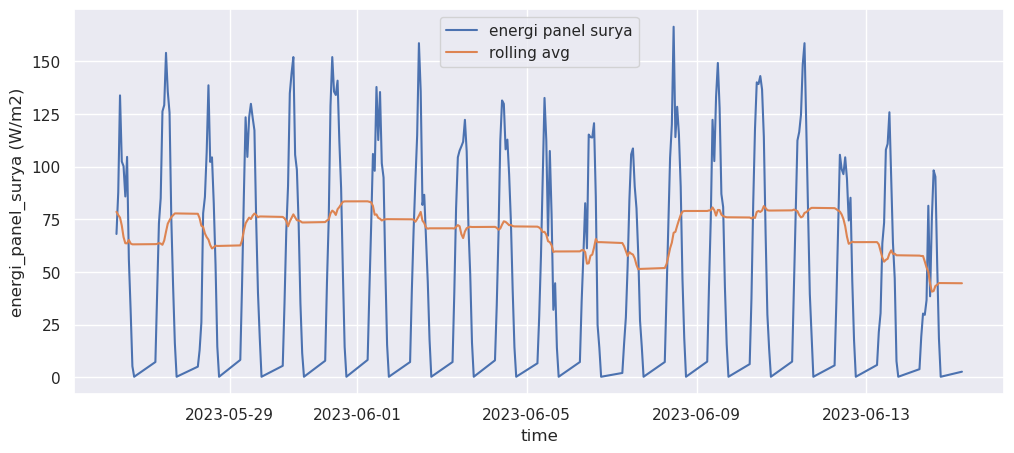

In [17]:
sns.set(rc={'figure.figsize':(12, 5)})

sns.lineplot(x = 'time',
             y = 'energi_panel_surya (W/m2)',
             data = df_roll[111100:],
             label = 'energi panel surya')
sns.lineplot(x = 'time',
             y = 'rolling_avg_energi_panel_surya (W/m2)',
             data = df_roll[111100:],
             label = 'rolling avg')

**Korelasi fitur**

In [18]:
df_float = df.drop(columns = 'time')
df_float = df_float.astype(float)
correlation_matrix = df_float.corr()['energi_panel_surya (W/m2)']

# Memilih fitur-fitur dengan korelasi di atas nilai absolut 0.75
selected_features = correlation_matrix[abs(correlation_matrix) > 0.75].index.tolist()

# Menampilkan nama fitur-fitur yang dipilih
print(selected_features)

['temperature_2m_best_match (°C)', 'relativehumidity_2m_best_match (%)', 'apparent_temperature_best_match (°C)', 'shortwave_radiation_best_match (W/m²)', 'direct_radiation_best_match (W/m²)', 'direct_normal_irradiance_best_match (W/m²)', 'et0_fao_evapotranspiration_best_match (mm)', 'vapor_pressure_deficit_best_match (kPa)', 'temperature_2m_era5 (°C)', 'relativehumidity_2m_era5 (%)', 'shortwave_radiation_era5 (W/m²)', 'direct_radiation_era5 (W/m²)', 'direct_normal_irradiance_era5 (W/m²)', 'et0_fao_evapotranspiration_era5 (mm)', 'vapor_pressure_deficit_era5 (kPa)', 'temperature_2m_era5_land (°C)', 'relativehumidity_2m_era5_land (%)', 'vapor_pressure_deficit_era5_land (kPa)', 'energi_panel_surya (W/m2)']


In [19]:
selected_features = correlation_matrix[abs(correlation_matrix) > 0.7].index.tolist()

# Menampilkan nama fitur-fitur yang dipilih
print(selected_features)

['temperature_2m_best_match (°C)', 'relativehumidity_2m_best_match (%)', 'apparent_temperature_best_match (°C)', 'shortwave_radiation_best_match (W/m²)', 'direct_radiation_best_match (W/m²)', 'diffuse_radiation_best_match (W/m²)', 'direct_normal_irradiance_best_match (W/m²)', 'et0_fao_evapotranspiration_best_match (mm)', 'vapor_pressure_deficit_best_match (kPa)', 'soil_temperature_0_to_7cm_best_match (°C)', 'temperature_2m_era5 (°C)', 'relativehumidity_2m_era5 (%)', 'apparent_temperature_era5 (°C)', 'shortwave_radiation_era5 (W/m²)', 'direct_radiation_era5 (W/m²)', 'diffuse_radiation_era5 (W/m²)', 'direct_normal_irradiance_era5 (W/m²)', 'et0_fao_evapotranspiration_era5 (mm)', 'vapor_pressure_deficit_era5 (kPa)', 'temperature_2m_era5_land (°C)', 'relativehumidity_2m_era5_land (%)', 'vapor_pressure_deficit_era5_land (kPa)', 'soil_temperature_0_to_7cm_era5_land (°C)', 'energi_panel_surya (W/m2)']


<Figure size 1000x500 with 0 Axes>

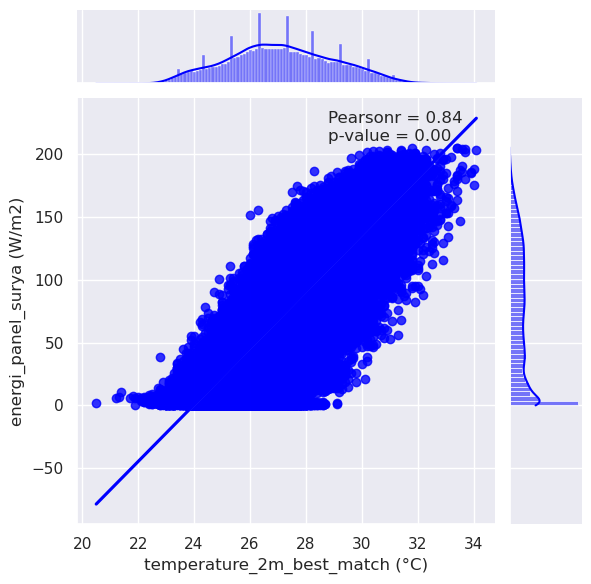

<Figure size 1000x500 with 0 Axes>

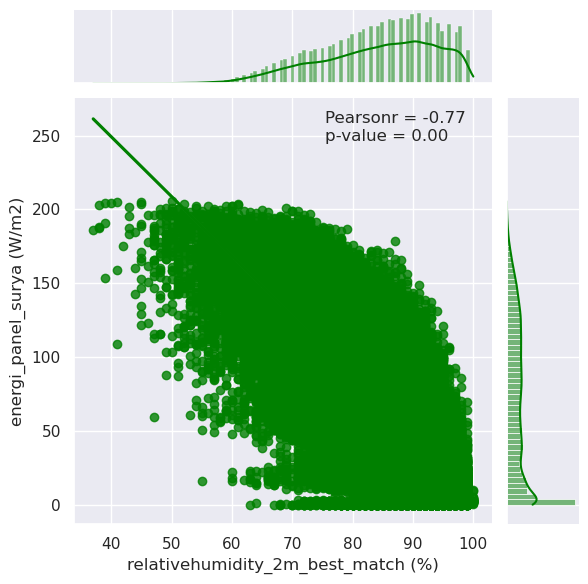

<Figure size 1000x500 with 0 Axes>

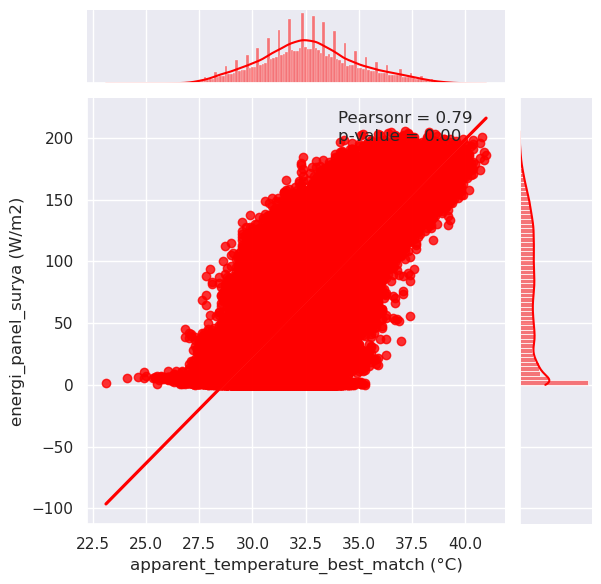

<Figure size 1000x500 with 0 Axes>

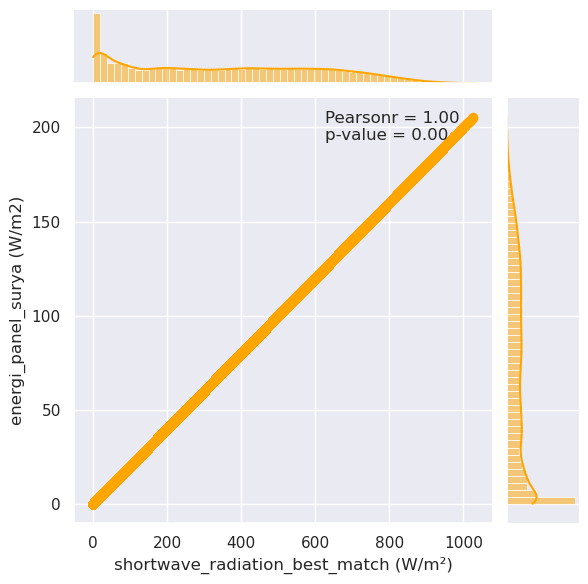

<Figure size 1000x500 with 0 Axes>

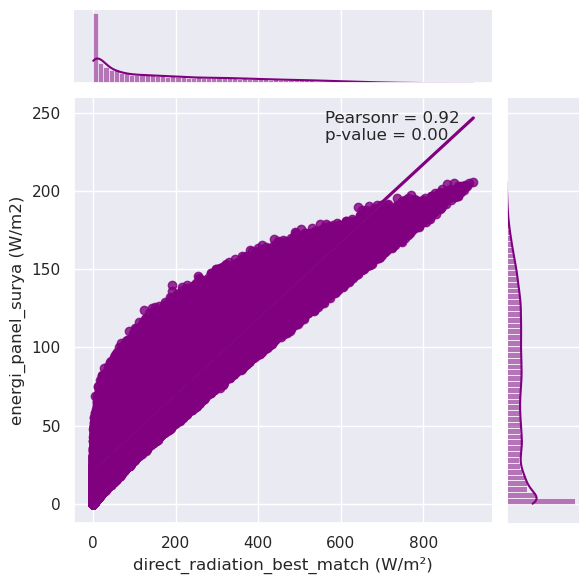

<Figure size 1000x500 with 0 Axes>

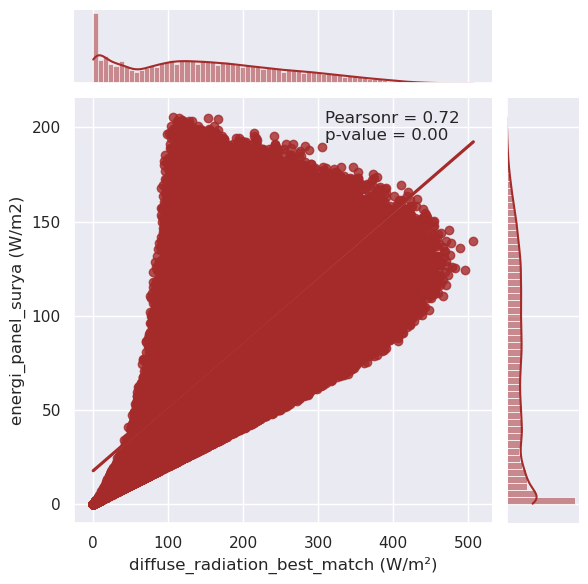

<Figure size 1000x500 with 0 Axes>

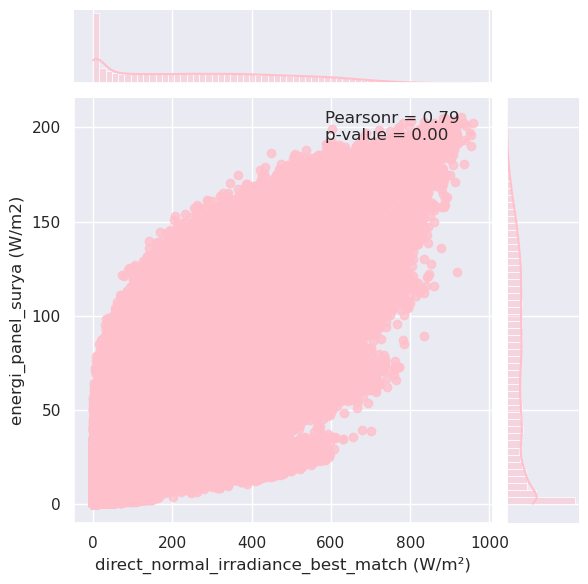

<Figure size 1000x500 with 0 Axes>

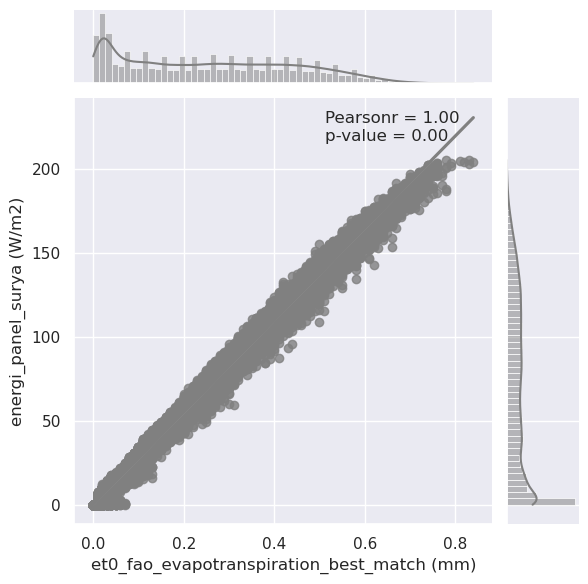

<Figure size 1000x500 with 0 Axes>

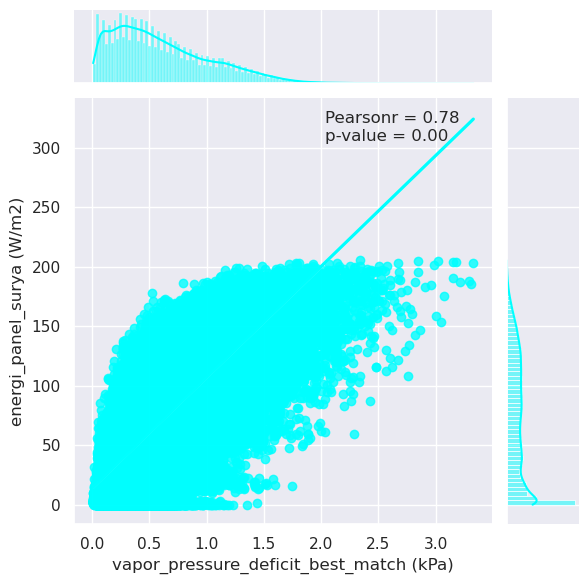

<Figure size 1000x500 with 0 Axes>

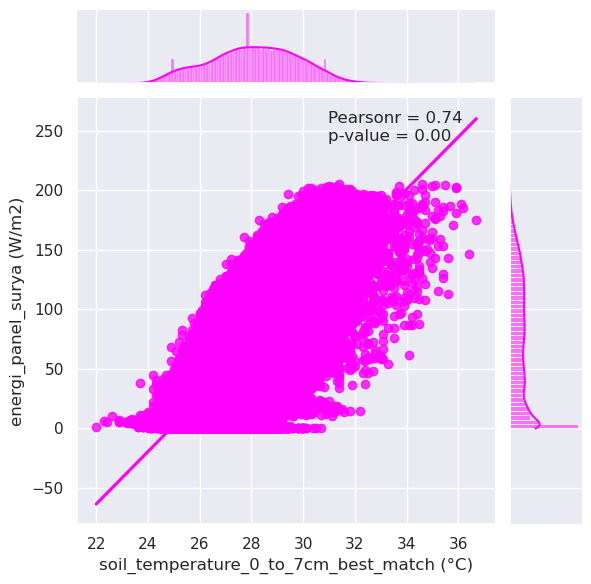

In [20]:
import scipy.stats as stats

features = ['temperature_2m_best_match (°C)', 'relativehumidity_2m_best_match (%)', 'apparent_temperature_best_match (°C)', 
            'shortwave_radiation_best_match (W/m²)', 'direct_radiation_best_match (W/m²)', 'diffuse_radiation_best_match (W/m²)', 
            'direct_normal_irradiance_best_match (W/m²)', 'et0_fao_evapotranspiration_best_match (mm)', 
            'vapor_pressure_deficit_best_match (kPa)', 'soil_temperature_0_to_7cm_best_match (°C)']

colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

sns.set(style="darkgrid", color_codes=True)

for i, feature in enumerate(features):
    plt.figure(figsize=(10, 5))
    j = sns.jointplot(x=feature, y='energi_panel_surya (W/m2)', data=df_float, kind='reg', color=colors[i % len(colors)])
    pearson_coef, p_value = stats.pearsonr(df_float[feature], df_float['energi_panel_surya (W/m2)'])
    j.ax_joint.annotate(f"Pearsonr = {pearson_coef:.2f}\np-value = {p_value:.2f}", xy=(0.6, 0.9), xycoords='axes fraction')
    plt.show()

# TEST 1 (Jika radiation diikut sertakan)

In [21]:
columns = ['temperature_2m_best_match (°C)', 'relativehumidity_2m_best_match (%)', 'apparent_temperature_best_match (°C)', 
           'shortwave_radiation_best_match (W/m²)', 'direct_radiation_best_match (W/m²)', 'diffuse_radiation_best_match (W/m²)', 
           'direct_normal_irradiance_best_match (W/m²)','et0_fao_evapotranspiration_best_match (mm)', 
           'vapor_pressure_deficit_best_match (kPa)', 'soil_temperature_0_to_7cm_best_match (°C)']
df[columns]

,temperature_2m_best_match (°C),relativehumidity_2m_best_match (%),apparent_temperature_best_match (°C),shortwave_radiation_best_match (W/m²),direct_radiation_best_match (W/m²),diffuse_radiation_best_match (W/m²),direct_normal_irradiance_best_match (W/m²),et0_fao_evapotranspiration_best_match (mm),vapor_pressure_deficit_best_match (kPa),soil_temperature_0_to_7cm_best_match (°C)
0,23.2,98,28,25,1,24,0,0.02,0.04,25
1,23.9,94,28.7,112,24,88,44.5,0.08,0.18,25.4
2,25,91,30,234,60,174,95.3,0.16,0.3,26
3,26.5,89,32.3,468,187,281,192.4,0.32,0.39,27.3
4,28.2,77,34,614,251,363,297.3,0.44,0.87,28.3
...,...,...,...,...,...,...,...,...,...,...
111354,29.1,74,34.1,476,352,124,451.2,0.34,1.06,29
111355,28.5,77,33.5,271,163,108,524.1,0.2,0.89,28.7
111356,27.7,83,33.3,92,50,42,353.8,0.07,0.65,28
111357,27,88,32.9,1,0,1,16.2,0.02,0.43,27.3


# Feature Scaling

In [22]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler_df = scaler.fit_transform(df[columns].astype(float))
scaler_df = pd.DataFrame(scaler_df, columns = df[columns].columns)
scaler_df

,temperature_2m_best_match (°C),relativehumidity_2m_best_match (%),apparent_temperature_best_match (°C),shortwave_radiation_best_match (W/m²),direct_radiation_best_match (W/m²),diffuse_radiation_best_match (W/m²),direct_normal_irradiance_best_match (W/m²),et0_fao_evapotranspiration_best_match (mm),vapor_pressure_deficit_best_match (kPa),soil_temperature_0_to_7cm_best_match (°C)
0,-2.066078,1.425200,-2.031410,-1.286402,-1.021498,-1.228230,-1.266852,-1.274336,-1.324698,-1.795175
1,-1.697226,1.018166,-1.728358,-0.947539,-0.903473,-0.629126,-1.064952,-0.953084,-1.000677,-1.564080
2,-1.117600,0.712890,-1.165546,-0.472352,-0.718740,0.175920,-0.834469,-0.524747,-0.722945,-1.217438
3,-0.327202,0.509373,-0.169801,0.439073,-0.067042,1.177547,-0.393920,0.331926,-0.514646,-0.466380
4,0.568583,-0.711731,0.566184,1.007740,0.261373,1.945149,0.082019,0.974432,0.596284,0.111356
...,...,...,...,...,...,...,...,...,...,...
111354,1.042822,-1.017007,0.609477,0.470233,0.779653,-0.292130,0.780274,0.439011,1.036027,0.515772
111355,0.726662,-0.711731,0.349718,-0.328237,-0.190198,-0.441906,1.111026,-0.310579,0.642573,0.342451
111356,0.305117,-0.101179,0.263131,-1.025438,-0.770055,-1.059732,0.338363,-1.006626,0.087108,-0.061965
111357,-0.063736,0.407614,0.089958,-1.379881,-1.026629,-1.443533,-1.193351,-1.274336,-0.422068,-0.466380


In [23]:
df_y = df['energi_panel_surya (W/m2)'].astype(float)
df_y = np.array(df_y)  # Convert to numpy array
df_y = df_y.reshape(-1, 1)  # Reshape to 2D array
Y_scaler = scaler.fit_transform(df_y)
Y_scaler = pd.DataFrame(Y_scaler, columns = ['energi_panel_surya (W/m2)'])
Y_scaler

,energi_panel_surya (W/m2)
0,-1.286402
1,-0.947539
2,-0.472352
3,0.439073
4,1.007740
...,...
111354,0.470233
111355,-0.328237
111356,-1.025438
111357,-1.379881


# Model LSTM

**Cek GPU**

In [24]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 613121726704579816
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14352646144
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 8918232674017518281
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14352646144
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 9188656515590517330
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
xla_global_id: 2144165316
]


**Split Test**

In [25]:
X_train, y_train = scaler_df[:70000], Y_scaler[:70000]
X_val, y_val = scaler_df[70000:80000], Y_scaler[70000:80000]
X_test, y_test = scaler_df[80000:], Y_scaler[80000:]

In [26]:
from keras.layers import Dense, LSTM, Input, Lambda
from keras.models import Sequential
import keras.backend as K

def attention(inputs):
    hidden_states = inputs
    hidden_size = int(hidden_states.shape[2])
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
    score = dot([score_first_part, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)
    context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
    return attention_vector

model = Sequential()
model.add(Input((10, 1)))
model.add(LSTM(128, return_sequences=True))
model.add(Attention())
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           66560     
                                                                 
 attention (Attention)       (None, 128)               49152     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 115,841
Trainable params: 115,841
Non-trainable params: 0
_________________________________________________________________


In [27]:
checkpoint = ModelCheckpoint('model/', save_best_only = True)
model.compile(
    loss = MeanSquaredError(),
    optimizer = Adam(learning_rate=0.0001),
    metrics = [RootMeanSquaredError()])

In [28]:
history = model.fit(X_train, y_train,
         validation_data = (X_val, y_val),
         epochs = 20,
         callbacks=[checkpoint])

Epoch 1/20
2188/2188 [==============================] - 27s 9ms/step - loss: 0.0249 - root_mean_squared_error: 0.1578 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0812
Epoch 2/20
2188/2188 [==============================] - 19s 9ms/step - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0716
Epoch 3/20
2188/2188 [==============================] - 19s 9ms/step - loss: 0.0043 - root_mean_squared_error: 0.0660 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0668
Epoch 4/20
2188/2188 [==============================] - 19s 9ms/step - loss: 0.0033 - root_mean_squared_error: 0.0575 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569
Epoch 5/20
2188/2188 [==============================] - 18s 8ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 6.6914e-04 - val_root_mean_squared_error: 0.0259
Epoch 6/20
2188/2188 [==============================] - 19s 9ms/step - loss: 3.4120e-04 - root_mean_squared_error: 0.0185

**BISMILLAH PREDICT**

In [29]:
y_pred = model.predict(X_test)

980/980 [==============================] - 3s 3ms/step


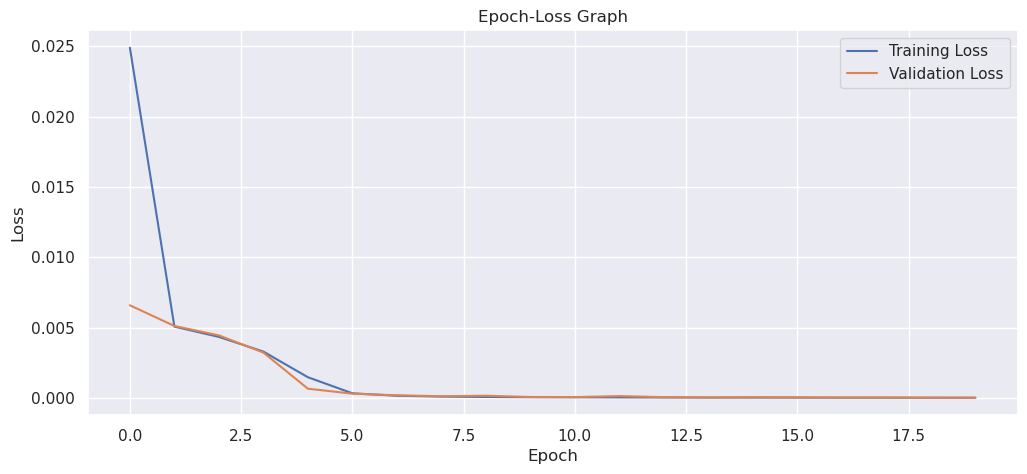

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch-Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Menghitung MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Menghitung MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Menghitung R^2 score
r2 = r2_score(y_test, y_pred)
print("Coefficient of Determination (R^2 Score):", r2)

Mean Squared Error (MSE): 1.8680484035921334e-05
Mean Absolute Error (MAE): 0.0034123883635382418
Coefficient of Determination (R^2 Score): 0.999981368030881


In [32]:
hasil = pd.DataFrame (y_pred, columns = ['pred_energi_panel_surya (W/m2)'])

In [33]:
y_test.reset_index(drop = True, inplace = True)
y_test

,energi_panel_surya (W/m2)
0,-1.165658
1,-1.383776
2,-1.115023
3,-0.386662
4,0.306644
...,...
31354,0.470233
31355,-0.328237
31356,-1.025438
31357,-1.379881


In [34]:
df_waktu = df['time'][80000:]
df_waktu.reset_index(drop = True, inplace = True)

In [35]:
df_waktu

0       2016-11-05 17:00:00
1       2016-11-05 18:00:00
2       2016-11-06 06:00:00
3       2016-11-06 07:00:00
4       2016-11-06 08:00:00
                ...        
31354   2023-06-14 15:00:00
31355   2023-06-14 16:00:00
31356   2023-06-14 17:00:00
31357   2023-06-14 18:00:00
31358   2023-06-15 06:00:00
Name: time, Length: 31359, dtype: datetime64[ns]

In [36]:
test_1 = pd.concat([y_test, hasil, df_waktu], axis = 1)
test_1

,energi_panel_surya (W/m2),pred_energi_panel_surya (W/m2),time
0,-1.165658,-1.159719,2016-11-05 17:00:00
1,-1.383776,-1.380265,2016-11-05 18:00:00
2,-1.115023,-1.118533,2016-11-06 06:00:00
3,-0.386662,-0.385506,2016-11-06 07:00:00
4,0.306644,0.307141,2016-11-06 08:00:00
...,...,...,...
31354,0.470233,0.468262,2023-06-14 15:00:00
31355,-0.328237,-0.335244,2023-06-14 16:00:00
31356,-1.025438,-1.028244,2023-06-14 17:00:00
31357,-1.379881,-1.386312,2023-06-14 18:00:00


<Axes: xlabel='time', ylabel='energi_panel_surya (W/m2)'>

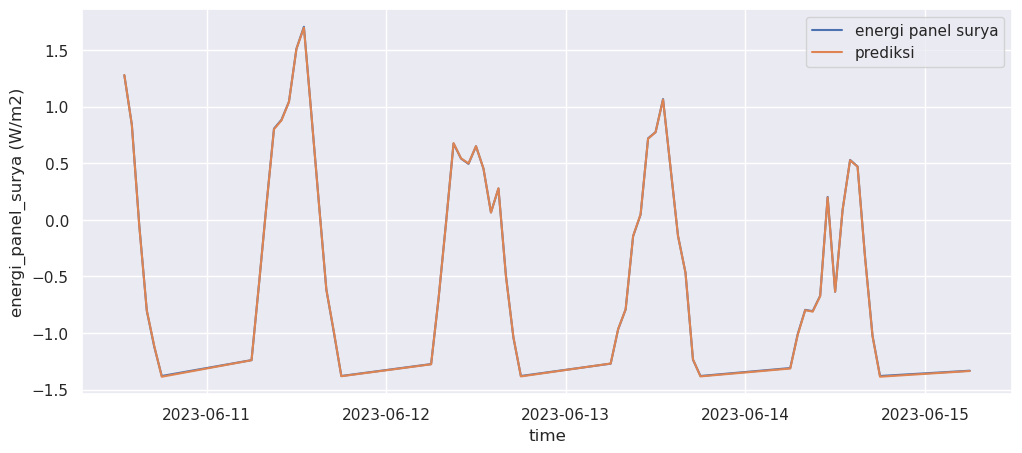

In [37]:
sns.set(rc={'figure.figsize':(12, 5)})

sns.lineplot(x = 'time',
             y = 'energi_panel_surya (W/m2)',
             data = test_1[31300:],
             label = 'energi panel surya')
sns.lineplot(x = 'time',
             y = 'pred_energi_panel_surya (W/m2)',
             data = test_1[31300:],
             label = 'prediksi')

# Test 2 (Tanpa radiasi matahari)

In [38]:
df_2 = df[columns].drop(columns =['shortwave_radiation_best_match (W/m²)', 'direct_radiation_best_match (W/m²)', 'diffuse_radiation_best_match (W/m²)', 
           'direct_normal_irradiance_best_match (W/m²)'])
df_2

,temperature_2m_best_match (°C),relativehumidity_2m_best_match (%),apparent_temperature_best_match (°C),et0_fao_evapotranspiration_best_match (mm),vapor_pressure_deficit_best_match (kPa),soil_temperature_0_to_7cm_best_match (°C)
0,23.2,98,28,0.02,0.04,25
1,23.9,94,28.7,0.08,0.18,25.4
2,25,91,30,0.16,0.3,26
3,26.5,89,32.3,0.32,0.39,27.3
4,28.2,77,34,0.44,0.87,28.3
...,...,...,...,...,...,...
111354,29.1,74,34.1,0.34,1.06,29
111355,28.5,77,33.5,0.2,0.89,28.7
111356,27.7,83,33.3,0.07,0.65,28
111357,27,88,32.9,0.02,0.43,27.3


**Feature Scaling**

In [39]:
scaler_df_2 = scaler.fit_transform(df_2)
scaler_df_2 = pd.DataFrame(scaler_df_2, columns = df_2.columns)
scaler_df_2

,temperature_2m_best_match (°C),relativehumidity_2m_best_match (%),apparent_temperature_best_match (°C),et0_fao_evapotranspiration_best_match (mm),vapor_pressure_deficit_best_match (kPa),soil_temperature_0_to_7cm_best_match (°C)
0,-2.066078,1.425200,-2.031410,-1.274336,-1.324698,-1.795175
1,-1.697226,1.018166,-1.728358,-0.953084,-1.000677,-1.564080
2,-1.117600,0.712890,-1.165546,-0.524747,-0.722945,-1.217438
3,-0.327202,0.509373,-0.169801,0.331926,-0.514646,-0.466380
4,0.568583,-0.711731,0.566184,0.974432,0.596284,0.111356
...,...,...,...,...,...,...
111354,1.042822,-1.017007,0.609477,0.439011,1.036027,0.515772
111355,0.726662,-0.711731,0.349718,-0.310579,0.642573,0.342451
111356,0.305117,-0.101179,0.263131,-1.006626,0.087108,-0.061965
111357,-0.063736,0.407614,0.089958,-1.274336,-0.422068,-0.466380


**Buat Model**

In [40]:
X_train, y_train = scaler_df_2[:70000], Y_scaler[:70000]
X_val, y_val = scaler_df_2[70000:80000], Y_scaler[70000:80000]
X_test, y_test = scaler_df_2[80000:], Y_scaler[80000:]

In [41]:
def attention(inputs):
    hidden_states = inputs
    hidden_size = int(hidden_states.shape[2])
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
    score = dot([score_first_part, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)
    context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
    return attention_vector

model = Sequential()
model.add(Input((6, 1)))
model.add(LSTM(128, return_sequences=True))
model.add(Attention())
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 6, 128)            66560     
                                                                 
 attention_1 (Attention)     (None, 128)               49152     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 115,841
Trainable params: 115,841
Non-trainable params: 0
_________________________________________________________________


In [42]:
checkpoint = ModelCheckpoint('model/', save_best_only = True)
model.compile(
    loss = MeanSquaredError(),
    optimizer = Adam(learning_rate=0.0001),
    metrics = [RootMeanSquaredError()])

In [43]:
history = model.fit(X_train, y_train,
         validation_data = (X_val, y_val),
         epochs = 20,
         callbacks=[checkpoint])

Epoch 1/20
2188/2188 [==============================] - 22s 9ms/step - loss: 0.0729 - root_mean_squared_error: 0.2700 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1256
Epoch 2/20
2188/2188 [==============================] - 14s 6ms/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1257
Epoch 3/20
2188/2188 [==============================] - 18s 8ms/step - loss: 0.0160 - root_mean_squared_error: 0.1266 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 4/20
2188/2188 [==============================] - 15s 7ms/step - loss: 0.0157 - root_mean_squared_error: 0.1252 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1235
Epoch 5/20
2188/2188 [==============================] - 13s 6ms/step - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1242
Epoch 6/20
2188/2188 [==============================] - 14s 6ms/step - loss: 0.0149 - root_mean_squared_error: 0.1220 - val_l

In [44]:
y_pred = model.predict(X_test)

980/980 [==============================] - 3s 3ms/step


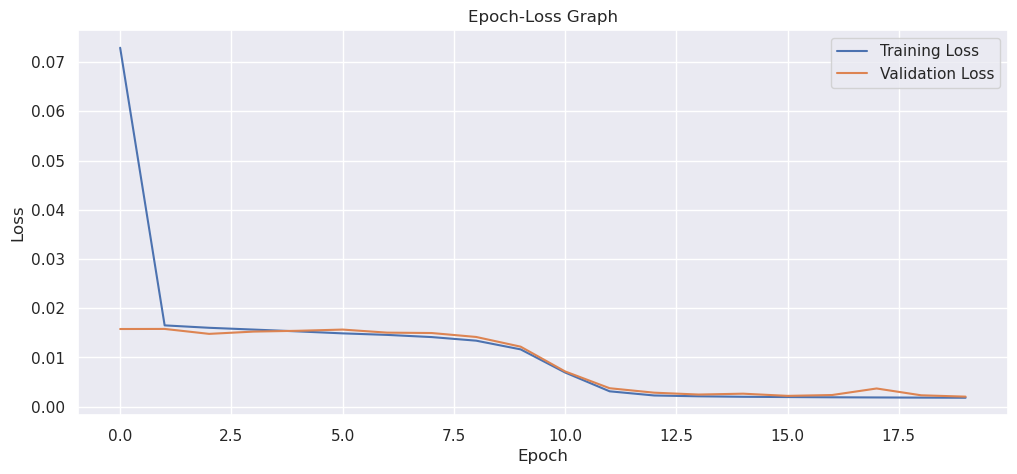

In [45]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch-Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Menghitung MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Menghitung MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Menghitung R^2 score
r2 = r2_score(y_test, y_pred)
print("Coefficient of Determination (R^2 Score):", r2)

Mean Squared Error (MSE): 0.0018934648696585894
Mean Absolute Error (MAE): 0.034994722290404366
Coefficient of Determination (R^2 Score): 0.9981114526309041


In [47]:
hasil = pd.DataFrame (y_pred, columns = ['pred_energi_panel_surya (W/m2)'])

In [48]:
y_test.reset_index(drop = True, inplace = True)
y_test

,energi_panel_surya (W/m2)
0,-1.165658
1,-1.383776
2,-1.115023
3,-0.386662
4,0.306644
...,...
31354,0.470233
31355,-0.328237
31356,-1.025438
31357,-1.379881


In [49]:
test_1 = pd.concat([y_test, hasil, df_waktu], axis = 1)
test_1

,energi_panel_surya (W/m2),pred_energi_panel_surya (W/m2),time
0,-1.165658,-1.158549,2016-11-05 17:00:00
1,-1.383776,-1.382072,2016-11-05 18:00:00
2,-1.115023,-1.166067,2016-11-06 06:00:00
3,-0.386662,-0.456020,2016-11-06 07:00:00
4,0.306644,0.273291,2016-11-06 08:00:00
...,...,...,...
31354,0.470233,0.392877,2023-06-14 15:00:00
31355,-0.328237,-0.345015,2023-06-14 16:00:00
31356,-1.025438,-1.035837,2023-06-14 17:00:00
31357,-1.379881,-1.293553,2023-06-14 18:00:00


<Axes: xlabel='time', ylabel='energi_panel_surya (W/m2)'>

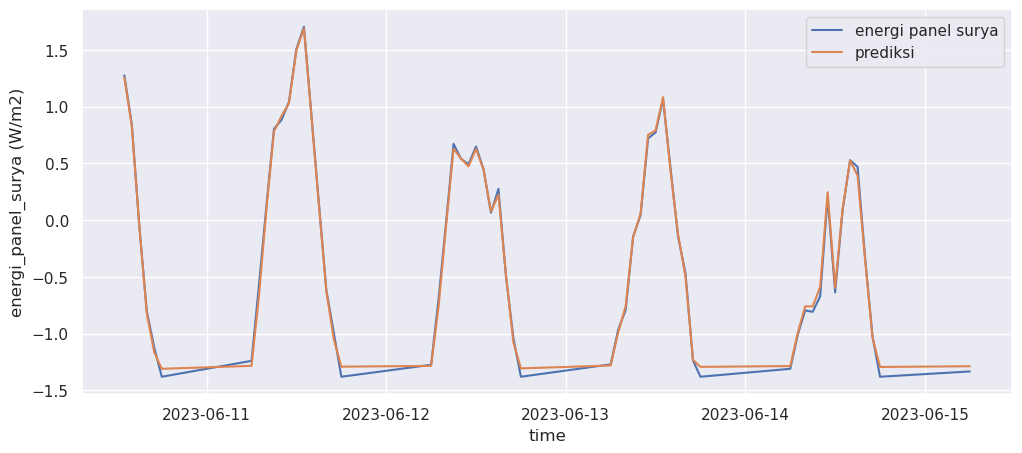

In [50]:
sns.set(rc={'figure.figsize':(12, 5)})

sns.lineplot(x = 'time',
             y = 'energi_panel_surya (W/m2)',
             data = test_1[31300:],
             label = 'energi panel surya')
sns.lineplot(x = 'time',
             y = 'pred_energi_panel_surya (W/m2)',
             data = test_1[31300:],
             label = 'prediksi')